In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import numpy as np
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import symmertic_insertion_seqs_gen

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# parameters
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8 
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# CTCT_table = "./top10_boundary.tsv"
CTCT_table = "./top10_dot.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

### Loading model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Reading CTCF table

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df.sample(n=10)
num_experiments = len(seq_coords_df)

### Predictions for (reference) background sequences

In [7]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

num_insert_backgrounds = seq_coords_df["background_index"].max()

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [8]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 10s 2s/step


### Predictions for specified insertions

In [9]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [10]:
# plotting parameters
vmin=-0.6
vmax=0.6
width=5
height=5
palette="RdBu_r"

experiment 0
2/2 [==============================] - 11s 2s/step


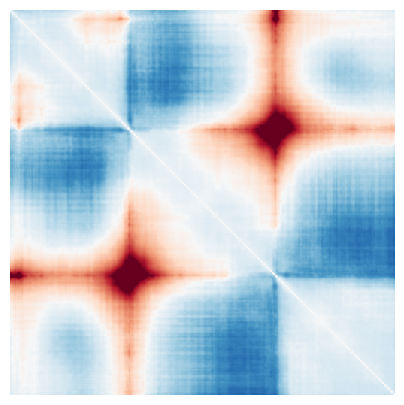

experiment 1


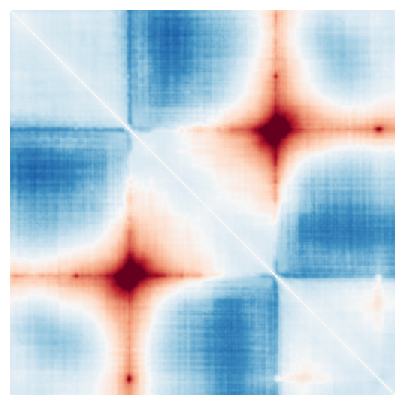

experiment 2


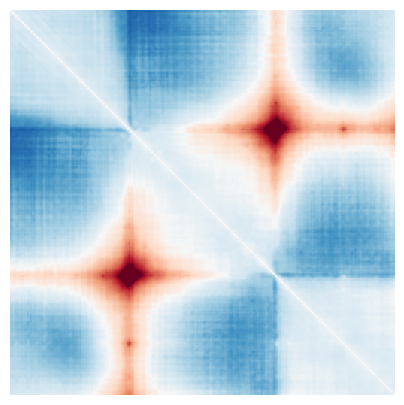

In [11]:
# for exp_index in range(num_experiments):
for exp_index in range(3):
    
    print(f"experiment {exp_index}")

    prediction_matrix = preds_stream[exp_index]
    # reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]
    # ref_maps_t0 = ut_dense(reference_prediction_matrix)
    alt_maps_t0 = ut_dense(prediction_matrix)

    fig = plt.figure(figsize=(width, height))
    
    sns.heatmap(
        alt_maps_t0[:,:,0],
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    #plt.savefig(f"./example_maps/boundary_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    #plt.savefig(f"./example_maps/boundary_{exp_index}.png", format="png", bbox_inches="tight")
    
    # plt.savefig(f"./example_maps/dot_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"./example_maps/dot_{exp_index}.png", format="png", bbox_inches="tight")
    plt.show()

In [12]:
genome_open.close()